In [1]:
!pip install gensim==3.8.3
import gensim
print(gensim.__version__)

3.8.3


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from konlpy.tag import Mecab

import re
import os
import random
import math

import gensim

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/'

In [4]:
df = pd.read_csv('/aiffel/data/ChatbotData.csv')

In [5]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
df.label.value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

0 : 일상, 1 : 이별(부정), 2 : 사랑(긍정)

In [7]:
# 결측치 없음

print(df.shape)
df.dropna(how='any', inplace=True)
print(df.shape)

(11823, 3)
(11823, 3)


In [8]:
# Q, A가 모두 같은 쌍은 없음

print('before dropping duplicates : ', df.shape)
df.drop_duplicates(inplace=True, ignore_index=True)
print('after dropping duplicates : ', df.shape)

before dropping duplicates :  (11823, 3)
after dropping duplicates :  (11823, 3)


In [9]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()  # 소문자화
    sentence = re.sub(r'[" "]+', " ", sentence)  # 연속 공백 처리
    sentence = re.sub(r"[^0-9가-힣a-zA-Z?.!,]+", " ", sentence)
    
    return sentence

In [10]:
def build_corpus(Q, A):
    que_corpus = []
    ans_corpus = []

    for pair in zip(Q, A):
        (q, a) = pair

        que_corpus.append(preprocess_sentence(q))
        ans_corpus.append(preprocess_sentence(a))
        
    mecab = Mecab()
    
    que_corpus = [mecab.morphs(x) for x in que_corpus]
    ans_corpus = [mecab.morphs(x) for x in ans_corpus]
    
    # 토큰 길이 어차피 얼마 안돼서 그냥 다 씀. MAX LENGTH = 32 tokens
    
    return que_corpus, ans_corpus
    # 소스:타겟 쌍 중복 데이터는 없고, 소스, 타겟에 대한 중복데이터는 있으나 왜 제거하는지? 어차피 나중에 augmentation도 할꺼면서. 중복 제거없이 그냥 하겠음.

In [11]:
que_corpus, ans_corpus = build_corpus(df['Q'], df['A'])

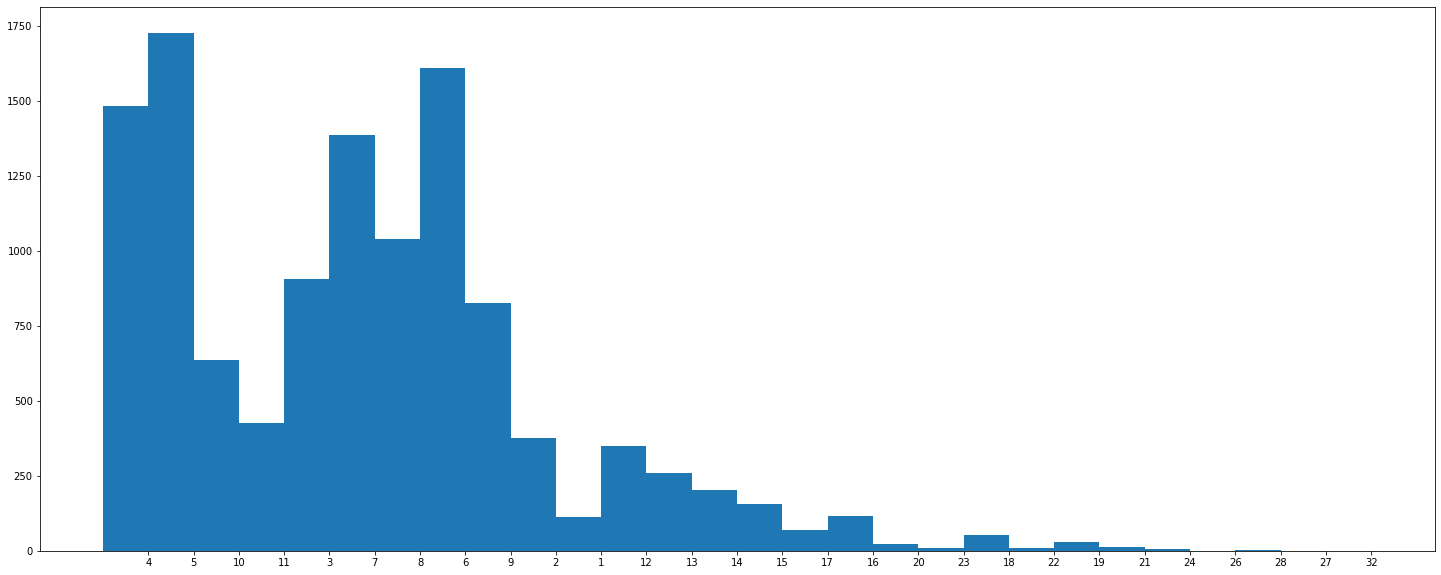

In [12]:
from collections import Counter
l = [ len(x) for x in que_corpus ]

labels, values = zip(*Counter(l).items())

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(25,10))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [13]:
print(Counter(l))

Counter({5: 1726, 6: 1609, 4: 1482, 7: 1387, 8: 1038, 3: 906, 9: 826, 10: 637, 11: 425, 2: 375, 12: 350, 13: 259, 14: 203, 15: 155, 16: 116, 1: 112, 17: 70, 18: 52, 19: 28, 20: 24, 21: 13, 23: 10, 22: 9, 24: 6, 28: 2, 26: 1, 27: 1, 32: 1})


In [14]:
que_corpus[:10]

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['3', '박', '4', '일', '정도', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sd', '카드', '안', '돼'],
 ['sns', '맞', '팔', '왜', '안', '하', '지'],
 ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '시간', '낭비', '인데', '자꾸', '보', '게', '됨']]

In [15]:
ans_corpus[:10]

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고', '해', '보', '세요', '.'],
 ['시간', '을', '정하', '고', '해', '보', '세요', '.']]

In [16]:
len(que_corpus)

11823

## Step 4. Augmentation

In [17]:
from gensim.models import Word2Vec
model = Word2Vec.load('/aiffel/data/ko.bin')

In [18]:
model.wv.most_similar('사랑')

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

사랑과 가장 유사한 단어는 슬픔..

In [19]:
import random
import copy

def is_korean_string(s):
    # 한글로만 이루어졌는지 확인하는 정규 표현식
    return bool(re.fullmatch(r'[가-힣]+', s))

def augmentation(que, ans):
    aug_q = []
    aug_a = []
    
    for q, a in zip(que, ans):
        # 원본
        tmp_q, tmp_a = copy.deepcopy(q), copy.deepcopy(a)
        
        aug_q.append(q)
        aug_a.append(a)
        
        for _ in range(len(q)):
            idx = random.choice(range(len(q)))
            if is_korean_string(q[idx]):
                try:
                    q[idx] = model.wv.most_similar(q[idx])[0][0]
                    break
                except KeyError:
                    continue
        
        for _ in range(len(a)):
            idx = random.choice(range(len(a)))
            if is_korean_string(a[idx]):
                try:
                    a[idx] = model.wv.most_similar(a[idx])[0][0]
                    break
                except KeyError:
                    continue

        # Question Lexical Substitution
        aug_q.append(q)
        aug_a.append(tmp_a)

        # Answer Lexical Substitution
        aug_q.append(tmp_q)
        aug_a.append(a)
        
    return aug_q, aug_a

In [20]:
que_corpus, ans_corpus = augmentation(que_corpus, ans_corpus)

In [21]:
len(que_corpus)

35469

In [22]:
for q, a in zip(que_corpus[:20], ans_corpus[:20]):
    print(' '.join(q), ' | ', ' '.join(a))

12 시 끗 !  |  하루 가 또 놀드 네요 .
12 시 끗 !  |  하루 가 또 가 네요 .
12 시 땡 !  |  하루 가 또 놀드 네요 .
1 지망 학교의 떨어졌 어  |  무릎 해 드립니다 .
1 지망 학교의 떨어졌 어  |  위로 해 드립니다 .
1 지망 학교 떨어졌 어  |  무릎 해 드립니다 .
3 김 4 일 놀 러 가 고 싶 다  |  여행 은 언제나 괜찮 죠 .
3 김 4 일 놀 러 가 고 싶 다  |  여행 은 언제나 좋 죠 .
3 박 4 일 놀 러 가 고 싶 다  |  여행 은 언제나 괜찮 죠 .
3 박 4 일 정도 놀 러 가 고 싶 으며  |  여행 은 항상 좋 죠 .
3 박 4 일 정도 놀 러 가 고 싶 으며  |  여행 은 언제나 좋 죠 .
3 박 4 일 정도 놀 러 가 고 싶 다  |  여행 은 항상 좋 죠 .
ppl 강하 네  |  눈살 이 찌푸려 꼼짝 죠 .
ppl 강하 네  |  눈살 이 찌푸려 지 죠 .
ppl 심하 네  |  눈살 이 찌푸려 꼼짝 죠 .
sd 단말기 망가졌 어  |  다시 새로 사 ㄴ다는 게 마음 편해요 .
sd 단말기 망가졌 어  |  다시 새로 사 는 게 마음 편해요 .
sd 카드 망가졌 어  |  다시 새로 사 ㄴ다는 게 마음 편해요 .
sd 카드 못가 돼  |  다시 새로이 사 는 게 마음 편해요 .
sd 카드 못가 돼  |  다시 새로 사 는 게 마음 편해요 .


In [23]:
for i in range(len(ans_corpus)):
    ans_corpus[i] = ["<start>"] + ans_corpus[i] + ["<end>"]

In [24]:
l = [ len(x) for x in que_corpus ]
print(sorted(Counter(l).keys()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 32]


In [25]:
l = [ len(x) for x in ans_corpus ]
print(sorted(Counter(l).keys()))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 42]


In [26]:
def get_tokenizer(corpus, vocab_size):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        oov_token="<UNK>",
        num_words=vocab_size
    )

    tokenizer.fit_on_texts(corpus)
    
    if vocab_size is not None:
        words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]
    
    return tokenizer


concat = que_corpus + ans_corpus
tokenizer = get_tokenizer(concat, None)

print("Tokenizer Vocab Size:", f"{len(tokenizer.word_index):,}")

Tokenizer Vocab Size: 8,025


In [63]:
def encoding_sentence(copus, tokenizer):
    tensor = tokenizer.texts_to_sequences(copus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor, padding='post'
    )
    return tensor


enc_train = encoding_sentence(que_corpus, tokenizer)
dec_train = encoding_sentence(ans_corpus, tokenizer)

In [64]:
print(enc_train.shape, dec_train.shape)

(35469, 32) (35469, 42)


In [65]:
enc_test = enc_train[-100:]
dec_test = dec_train[-100:]

enc_train = enc_train[:-100]
dec_train = dec_train[:-100]

In [66]:
print(enc_train.shape, dec_train.shape)
print(enc_test.shape, dec_test.shape)

(35369, 32) (35369, 42)
(100, 32) (100, 42)


## Step 6. 훈련하기

In [67]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [68]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        """
        Scaled QK 값 구하기
        """
        
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [69]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [70]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [71]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [72]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


In [73]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [74]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [75]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [76]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [77]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

**HYPER PARAMETERS**

* tokenizer vocab_size가 8,000 정도라 여유있게 10,000으로 지정  
* (num_layers, dropout_rate) = (2, 0.2), (3, 0.5)로 실험

In [78]:
num_layers = 3
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = 10000
target_vocab_size = 10000
pos_len = 10000
dropout_rate = 0.5

# Transformer 모델 선언
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pos_len, dropout=dropout_rate)

In [79]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [106]:
def translate(sentence, model, tokenizer, enc_tensor, dec_tensor):
    enc_maxlen = enc_tensor.shape[-1]
    dec_maxlen = dec_tensor.shape[-1]

    sos_idx = tokenizer.word_index['<start>']
    eos_idx = tokenizer.word_index['<end>']

    sentence = preprocess_sentence(sentence)

    m = Mecab()
    sentence = m.morphs(sentence)

    _input = tokenizer.texts_to_sequences([sentence])
    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=enc_maxlen,
        padding='post'
    )

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output
        )

        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            _input, output, enc_padding_mask, combined_mask, dec_padding_mask
        )

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = tokenizer.sequences_to_texts([ids])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tokenizer.sequences_to_texts([ids])
    return result

In [108]:
def translate_vect(sentence, model, tokenizer, enc_tensor, dec_tensor):
    
    enc_maxlen = enc_tensor.shape[-1]
    dec_maxlen = dec_tensor.shape[-1]

    sos_idx = tokenizer.word_index['<start>']
    eos_idx = tokenizer.word_index['<end>']

    _input = sentence.reshape(1,32)

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output
        )

        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            _input, output, enc_padding_mask, combined_mask, dec_padding_mask
        )

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = tokenizer.sequences_to_texts([ids])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tokenizer.sequences_to_texts([ids])
    return result

In [82]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        ans = translate(example, transformer, tokenizer, enc_train, dec_train)[0]
        print(f"Quenstion: {example:<30}\tAnswer: {ans:<30}")

/tmp/ipykernel_203/582153402.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 그러 고 싶 은 분간 고 있 을 거 예요 .      
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 요즘 집 잠시 쉬 었 는 건 쉽 지 않 은데요 .   
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 좋 은 생각 이 에요 .                 
Quenstion: 집에 있는다는 소리야.                  	Answer: 좋 은 추억 이 네요 .                 


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 친구 들 과 연락 해 보 세요 .            
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 잠시 쉬 어도 돼요 .                  
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 항상 후회 하 죠 .                   
Quenstion: 집에 있는다는 소리야.                  	Answer: 안 좋 은 일 이 네요 .                


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 그러 고 싶 은 걸 두 세요 .             
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 집 잠시 쉬 어도 집 마련 많이 사 는 거 예요 .  
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 좋 아서 가 야죠 .                   
Quenstion: 집에 있는다는 소리야.                  	Answer: 네요 .                          


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 혼자 도 좋 은 이곳 이 에요 .            
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 요즘 바쁜가 봐요 .                   
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 좋 은 첫날 이 올 거 예요 .             
Quenstion: 집에 있는다는 소리야.                  	Answer: 이제 는 괜찮 아서 어요 .               


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 선생 님 이 도움 이 할 때 는 집 에 있 다는 게 할 거 예요 .
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 도록 드세요 .                   
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 어제 은 항상 힘들 죠 .                
Quenstion: 집에 있는다는 소리야.                  	Answer: 이제 는 괜찮 아요 .                  


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 생각 보다 잘 할 때 는 시간 이 네요 .       
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 게 드세요 .                    
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 공허 함 이 더 ㅂ시오 .                
Quenstion: 집에 있는다는 소리야.                  	Answer: 그때 결혼 해도 괜찮 죠 .               


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 금방 지나갈 거 예요 .                 
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 게 드세요 .                    
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 좋 은 하루 에 연락 하 세요 .            
Quenstion: 집에 있는다는 소리야.                  	Answer: 근육 쓰 고 새 집 에 는 새 집 에 있 어요 .   


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 저절로 지나갈 거 예요 .                
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 도록 드세요 .                   
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 기억 도 마세요 .                    
Quenstion: 집에 있는다는 소리야.                  	Answer: 이제 보하이 괜찮 은 기회 를 하 세요 .       


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 친구 들 과 마음 이 사세요 .             
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 도록 많이 부유층 어 보 세요 .         
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 죠 .                           
Quenstion: 집에 있는다는 소리야.                  	Answer: ㄴ다면 멋져요 .                     


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 무슨 일 잘 할 때 군요 .               
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 잠시 쉬 어도 돼요 .                  
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 좋 은 생각 이 에요 .                 
Quenstion: 집에 있는다는 소리야.                  	Answer: 그때 어렵 겠 어요 .                  


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 친구 들 과 마음 을 정리 때때 때 가 있 을 거 예요 .
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 금방 지나갈 거 예요 .                 
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 꿈 은 항상 예의 가 없 네요 .            
Quenstion: 집에 있는다는 소리야.                  	Answer: 이제 라도 재혼 할 때 네요 .             


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 제 랑 놀 아요 .                    
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 정리 하 는 게 많이 해서 매력 이 드세요 .     
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 기억 도 남 아 싶 어요 .               
Quenstion: 집에 있는다는 소리야.                  	Answer: 척 하 는 사람 이 네요 .               


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 바람 그러 라도 쐬 고 오 는 건 어떨까 요 .    
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 도록 해서 비 를 내 세요 .           
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 또 이별 은 ㅂ시오 .                  
Quenstion: 집에 있는다는 소리야.                  	Answer: 운명 적 인 곳 이 네요 .               


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 이 고 마음 을 바랄게요 .               
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 도록 를 거 라고 판단 해 보 세요 .      
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 꿈 은 예의 가 없 네요 .               
Quenstion: 집에 있는다는 소리야.                  	Answer: 신경 쓰 기 좋 죠 .                  


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 저 도 듣 고 싶 어요 .                
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 도록 드세요 .                   
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 긴 시간 이 라고 판단 하 세요 .           
Quenstion: 집에 있는다는 소리야.                  	Answer: 신경 쓰 는 새 좋 지 않 은 근육 쓰 고 있 어요 .


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 친구 들 과 마음 이 처럼 할 때 가 있 었 죠 .  
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 보다 일찍 를 바쁜가 봐요 .              
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 도 헤어지 은 더 힘들 겠 지만 ㅂ시오 .       
Quenstion: 집에 있는다는 소리야.                  	Answer: 새 는 예상 는 습관 이 에요 .            


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 연인 은 때때 때 괴로움 이 있 을 것 같 은데요 . 
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 보다 일찍 예민 한가 봐요 .              
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 득템 하 세요 .                     
Quenstion: 집에 있는다는 소리야.                  	Answer: ㄴ다면 좋 아요 .                    


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 그러 고 할 다면 그런 사람 이 네요 .        
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 맛있 을 거 로 건 생각 해 맛있 를 거 예요 .   
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 도 ㅂ시오 .                       
Quenstion: 집에 있는다는 소리야.                  	Answer: ㄴ다면 좋 아요 .                    


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 그러 고 할 때 마음 이 에요 .            
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 보다 일찍 사 는 거 취미 바쁜가 봐요 .       
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 한동안 은 어렵 겠 네요 .               
Quenstion: 집에 있는다는 소리야.                  	Answer: ㄴ다면 돼요 .                      


  0%|          | 0/553 [00:00<?, ?it/s]

Quenstion: 지루하다, 놀러가고 싶어.                	Answer: 그러 고 살 때 가 고 있 나 봐요 .         
Quenstion: 오늘 일찍 일어났더니 피곤하다.             	Answer: 아무 생각 하 지 말 고 빨리 집 은데 쉽 지 않 은데요 .
Quenstion: 간만에 여자친구랑 데이트 하기로 했어.         	Answer: 나이 놀드 남 예요 .                  
Quenstion: 집에 있는다는 소리야.                  	Answer: 신경 쓰이 겠 어요 .                  


### Case1. num_layers=2, drop_out = 0.2 

* 의미 있는 답변이 나오기도 하고, 몇몇 유사단어만 바꾸면 괜찮다 싶은 문장도 있었으나 대체로 문법이 맞지 않음.
* epoch가 진행될때 마다 답변이 일관성 없이 변함.

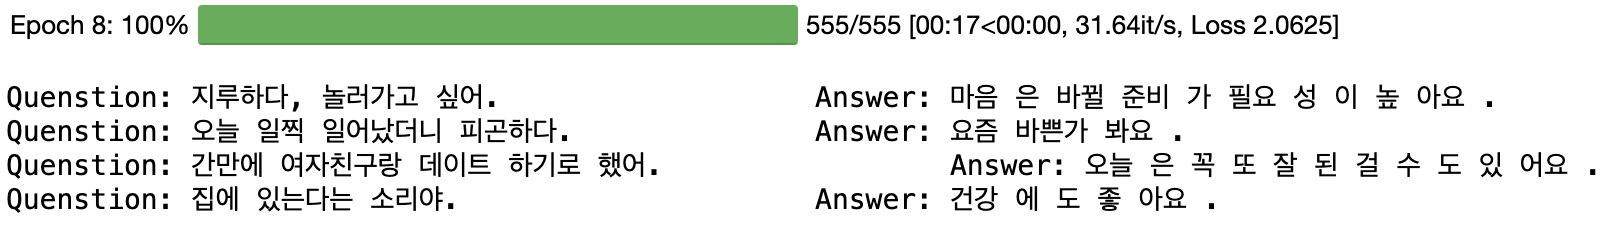

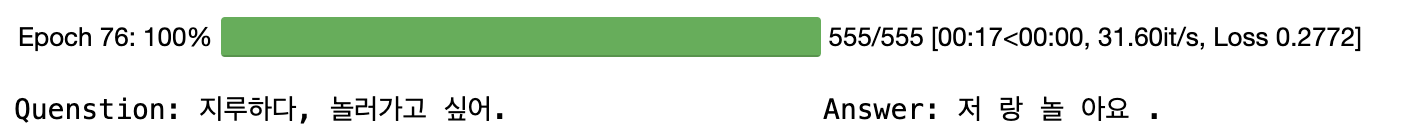

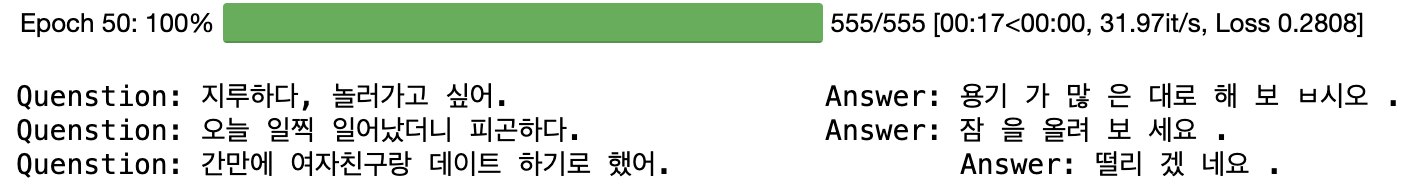

### Case2. num_layers=3, drop_out = 0.5

* 답변에서 표현되는 단어들이 질문에서 크게 벗어나지 않고 일관성 있음.
* epoch가 지나도 유사한 답변을 계속해서 하는 경우가 많음.(Case 1에서는 계속해서 답변이 크게 달라짐)
* 학습속도가 조금 느린것으로 보임. epoch 수를 늘리면 좋은 결과를 얻을 수 있을 것 같음.

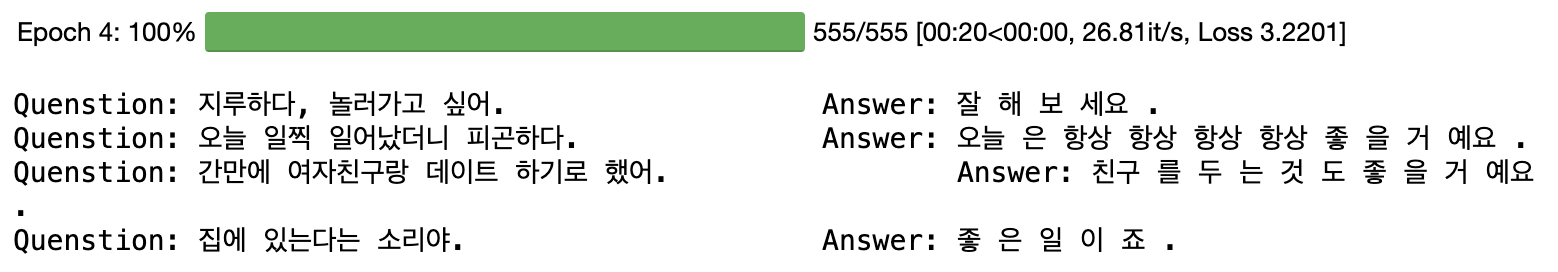

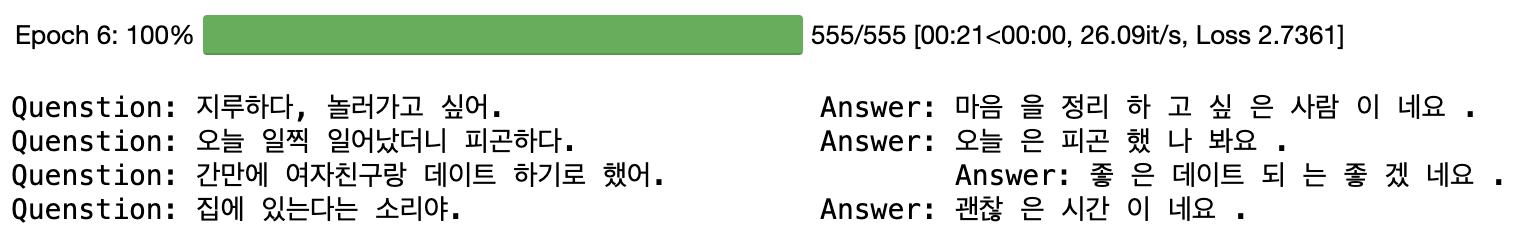

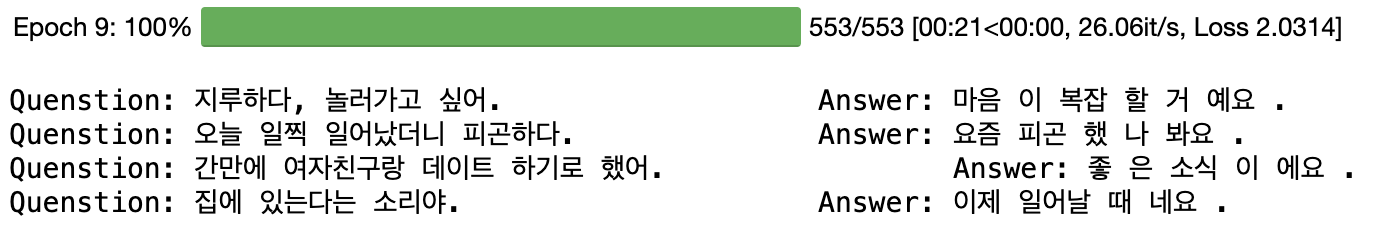

## Step 7. 성능 측정하기

In [83]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

In [123]:
score = 0
for i, test in enumerate(enc_test):
    ans = translate_vect(test, transformer, tokenizer, enc_train, dec_train)[0]
    score += calculate_bleu(label, ans)
    label = tokenizer.sequences_to_texts(dec_test)[i].split('<start>')[1].split('<end>')[0].strip()
    print(f"Label Answer: {label:<20}\tChatbot Answer: {ans:<20}")
    print("Case[", i+1, "] BLEU-Total:", calculate_bleu(label, ans), "\n")
    
print("\n")
print(f"평균 BLEU-Total Score : {score/len(enc_test)}")

Label Answer: 한두 번 말 을 걸 어 보 세요 . 	Chatbot Answer: 한두 번 말 을 걸 어 보 세요 . 
Case[ 0 ] BLEU-Total: 1.0 

Label Answer: 좋 아 하 ㄴ다면 유지 하 게 되 겠 지요 .	Chatbot Answer: 저 는 안 좋 아요 .        
Case[ 1 ] BLEU-Total: 0.053105967483755914 

Label Answer: 좋 아 하 면 유지 하 게 되 겠 지요 .	Chatbot Answer: 저 는 안 좋 아요 .        
Case[ 2 ] BLEU-Total: 0.06273728767223946 

Label Answer: 좋 아 하 ㄴ다면 유지 하 게 되 겠 지요 .	Chatbot Answer: 혼자 안 되 는지 직접 안 학원 을 다녀도 좋 아요 .
Case[ 3 ] BLEU-Total: 0.08583349408093285 

Label Answer: 잠깐 쉬 어도 괜찮 아요 .     	Chatbot Answer: 현실 적 인 확신 이 라 다시 죠 .
Case[ 4 ] BLEU-Total: 0.026801651563557783 

Label Answer: 잠시 쉬 어도 괜찮 아요 .     	Chatbot Answer: 현실 적 인 확신 이 라 다시 죠 .
Case[ 5 ] BLEU-Total: 0.03312498979466406 

Label Answer: 잠깐 쉬 어도 괜찮 아요 .     	Chatbot Answer: 현실 적 인 문제 가 중요 할 때 가 있 죠 .
Case[ 6 ] BLEU-Total: 0.02499302941518757 

Label Answer: 상관 없 는 거 같 은데요 .    	Chatbot Answer: 증오 를 ㄴ다는 바 엉덩이 을 보 세요 .
Case[ 7 ] BLEU-Total: 0.05970228993860437 

Label Answer: 상관 없 는 거 같 아요 .     	Chatbot Answer: 증오 

**평균 BLEU-Total Score : 0.08332720722296352**

## 회고

**배운점**

 * Transformer를 이용한 챗봇을 간단하게 만들어보았다.
  
**아쉬운점**

 * 챗봇의 답변이 썩 마음에 들지 않았다. 모델의 수준을 보면 당연한 결과지만 조금 아쉬웠다.
 
**느낀점**
 * 결과는 보았지만 모르는게 많다.
 * 질문1. 어차피 augmentation할건데 왜 질문-답변 중복항목을 지우는가?
 * 질문2. Augmentation에 쓰인 Word2Vec의 유사 단어가 그렇게 문장에서 바로 대체하기엔 유사하단 느낌이 들지 않는다.
 
**어려웠던 점**

 * 역시 데이터의 Shape이 바뀌면서 에러 잡을 일이 많았다. 예를들어 (32,)인 데이터를 (1,32)로 변환해야되는데 그걸 몰라서 시간을 오래 잡아 먹었다.
 * 항상 데이터의 Shape을 확인하는 습관을 들여야겠다.
 * BLEU Score 보다는 사람의 정성적 판단이 나은것같다. 여러가지 텍스트 생성 결과에 대한 평가방법에 대해 알아봐야겠다.